In [1]:
import os
import glob
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
import shutil
import PIL

Using TensorFlow backend.


In [2]:
!pwd

/media/hdd1/dataset/cats_dogs


In [3]:
dogs_trng = glob.glob("data/train/dogs/*")
cats_trng = glob.glob("data/train/cats/*") 
dogs_val = glob.glob("data/validation/dogs/*")
cats_val=glob.glob("data/validation/cats/*")
len(dogs_trng), len(cats_trng),len(dogs_val), len(cats_val)

(12501, 12501, 400, 399)

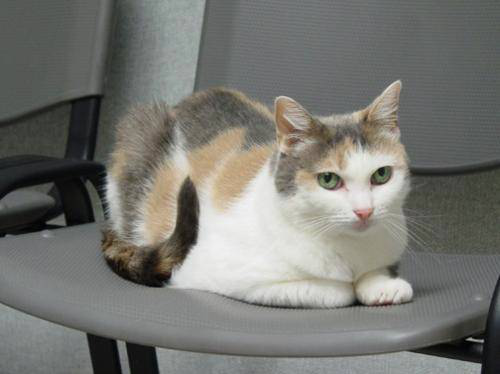

In [4]:
load_img(cats_trng[5])

In [5]:
#Build a Keras Graph
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers  import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [13]:
from keras.utils import multi_gpu_model

model = Sequential()
#First conv output of 32 layer 3,3 matrix
model.add(Conv2D(64,(3,3), input_shape=(299,299,3), padding="same" ))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
# Second Conv Layes
model.add(Conv2D(128,(3,3),padding="same" ))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256,(3,3),padding="same" ))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(512,(3,3),padding="same" ))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("elu"))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation("elu"))
model.add(Dropout(0.3))
model.add(Dense(1))
model.add(Activation("sigmoid"))
opt = keras.optimizers.Adagrad(lr=0.001)
#parallel_model = multi_gpu_model(model, gpus=2)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 299, 299, 64)      1792      
_________________________________________________________________
activation_7 (Activation)    (None, 299, 299, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 149, 149, 128)     73856     
_________________________________________________________________
activation_8 (Activation)    (None, 149, 149, 128)     0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 74, 74, 256)       295168    
__________

In [15]:
batch_size = 10
train_datagen =  ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2,horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
!ls data/train

cats  dogs


In [18]:
train_generator = train_datagen.flow_from_directory('data/train',target_size=(299,299), batch_size=10, class_mode="binary")

Found 25000 images belonging to 2 classes.


In [19]:
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='binary')

Found 799 images belonging to 2 classes.


In [20]:
import keras
#TBlogger = keras.callbacks.ModelCheckpoint("./logs", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
history = model.fit_generator(train_generator, steps_per_epoch=2500, epochs=20, validation_data=validation_generator, validation_steps=800, callbacks=[early_stopping])



Epoch 1/20
2500/2500 [==============================] - 581s 232ms/step - loss: 0.5462 - acc: 0.7212 - val_loss: 0.4265 - val_acc: 0.8073
Epoch 2/20
2500/2500 [==============================] - 526s 210ms/step - loss: 0.4223 - acc: 0.8066 - val_loss: 0.3664 - val_acc: 0.8461
Epoch 3/20
2500/2500 [==============================] - 526s 210ms/step - loss: 0.3673 - acc: 0.8388 - val_loss: 0.3191 - val_acc: 0.8636
Epoch 4/20
2500/2500 [==============================] - 526s 210ms/step - loss: 0.3330 - acc: 0.8572 - val_loss: 0.2833 - val_acc: 0.8924
Epoch 5/20
2500/2500 [==============================] - 526s 210ms/step - loss: 0.3061 - acc: 0.8686 - val_loss: 0.2525 - val_acc: 0.9024
Epoch 6/20
2500/2500 [==============================] - 524s 210ms/step - loss: 0.2842 - acc: 0.8789 - val_loss: 0.2367 - val_acc: 0.9161
Epoch 7/20
2500/2500 [==============================] - 526s 210ms/step - loss: 0.2653 - acc: 0.8890 - val_loss: 0.2332 - val_acc: 0.9124
Epoch 8/20
2500/2500 [============

In [21]:
model.save("cat_dog_modelgood.h5")

In [39]:
!ls -ltr models

total 1343392
-rw-rw-r-- 1 sdutta sdutta 1375627016 Jun 10 11:44 cat_dog_modelgood.h5


In [26]:
def convert_image_to_bgr_numpy_array(image_path, size=[224,224]):
    """The network has been trained using opencv and BGR images 
    (i.e. channels order blue, green, red rather than red, green, blue).
    The description of why is https://stackoverflow.com/questions/14556545/why-opencv-using-bgr-colour-space-instead-of-rgb
    
    We can use a simpler image library as long as we manually convert
    the data to the expected format.
    """
    image = PIL.Image.open(image_path).resize((size),PIL.Image.ADAPTIVE)
    img_data = np.array(image.getdata(), np.float32).reshape(224,224, -1)
    # swap R and B channels
    img_data = np.flip(img_data, axis=2)
    return img_data

def prepare_image(image_path):
    im = convert_image_to_bgr_numpy_array(image_path)

    # these subtractions are just mean centering the images 
    # based on known means for different color channels
    im[:,:,0] -= 103.939
    im[:,:,1] -= 116.779
    im[:,:,2] -= 123.68

    im = im.transpose((2,0,1)) # adjust from (224, 224, 3) to (3, 224, 224) for keras
    im = np.expand_dims(im, axis=0) # adjust to (1, 3, 224, 224) for generating keras prediction
    return im

### Transfer Learning using InceptionV3
- Faster learning rate

In [27]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
import keras
from keras.utils import multi_gpu_model
# note we exclude the final dense layers and add one back below, we would retrain it ourselves
#base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
inception_model = keras.applications.InceptionV3(weights='imagenet',
                               include_top=False,
                               pooling=None,
                               input_shape=(299, 299, 3))


inception_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_9[0][0]                   
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_10 

In [31]:

# Freeze convolutional layers
for layer in inception_model.layers:
    #print layer
    layer.trainable = False    
    


In [37]:
transfer_model = Sequential()
transfer_model.add(inception_model)
transfer_model.add(Flatten())
transfer_model.add(Dense(1024, activation="elu"))
transfer_model.add(Dropout(0.3))
transfer_model.add(Dense(512, activation="elu"))
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(1, activation="sigmoid"))

transfer_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.adam(lr=1e-4), metrics=["accuracy"])

In [38]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
transfer_history = transfer_model.fit_generator(train_generator, steps_per_epoch=2500, epochs=20, validation_data=validation_generator, validation_steps=800, callbacks=[early_stopping])

Epoch 1/20
2500/2500 [==============================] - 604s 241ms/step - loss: 0.7223 - acc: 0.9174 - val_loss: 0.0454 - val_acc: 0.9912
Epoch 2/20
2500/2500 [==============================] - 641s 257ms/step - loss: 0.1781 - acc: 0.9426 - val_loss: 0.0916 - val_acc: 0.9690
Epoch 3/20
2500/2500 [==============================] - 791s 316ms/step - loss: 0.1508 - acc: 0.9505 - val_loss: 0.0585 - val_acc: 0.9812
Epoch 4/20
2500/2500 [==============================] - 712s 285ms/step - loss: 0.1294 - acc: 0.9545 - val_loss: 0.0810 - val_acc: 0.9762
Epoch 5/20
2500/2500 [==============================] - 714s 286ms/step - loss: 0.1211 - acc: 0.9577 - val_loss: 0.0701 - val_acc: 0.9760
Epoch 6/20
2500/2500 [==============================] - 831s 333ms/step - loss: 0.1046 - acc: 0.9626 - val_loss: 0.0351 - val_acc: 0.9875


In [40]:
transfer_model.save("models/inception_trained_cat_dogs.h5")

In [41]:
from keras.utils.vis_utils import plot_model
plot_model(transfer_model, to_file='vgg.png')

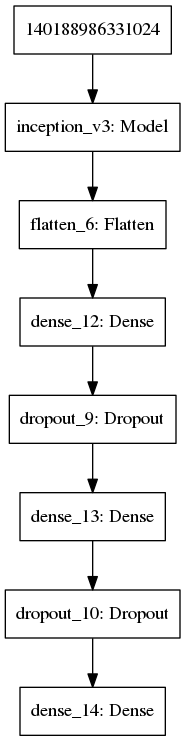

In [42]:
load_img("vgg.png")

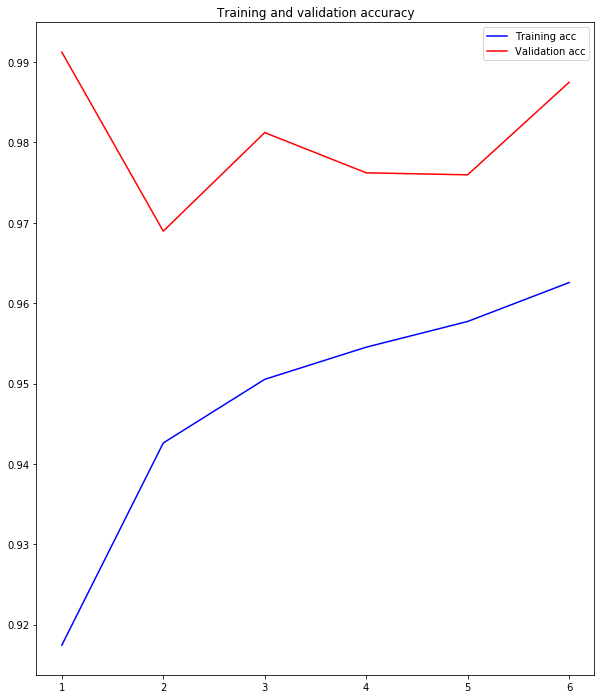

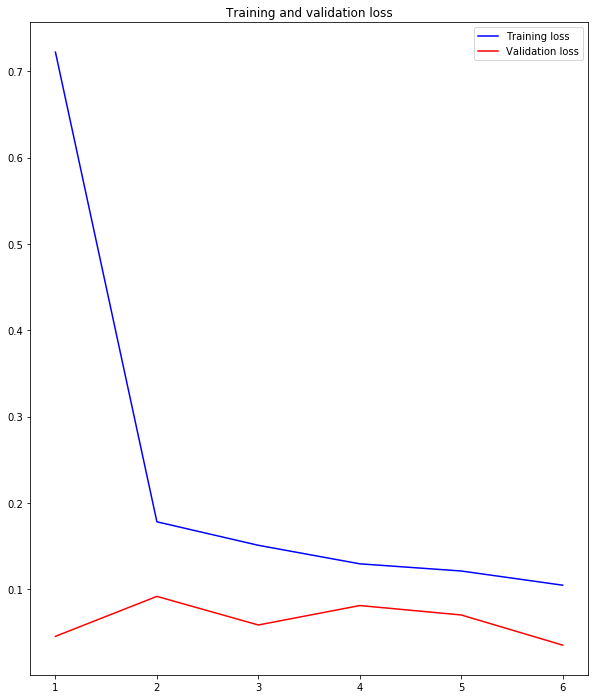

In [57]:
import matplotlib.pyplot as plt

%matplotlib inline
def plot_history(history):
    train_history = history
    acc = train_history.history['acc']
    val_acc = train_history.history['val_acc']
    loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(10,12))
    plt.plot(epochs, acc, 'blue', label='Training acc')
    plt.plot(epochs, val_acc, 'red', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    #plt.figure()
    plt.figure(figsize=(10,12))
    plt.plot(epochs, loss, 'blue', label='Training loss')
    plt.plot(epochs, val_loss, 'red', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    #plt.show()

#plt.subplot(2, 1, 1)    
#plot_history(history)
#plt.subplot(2, 1, 2)
plot_history(transfer_history)

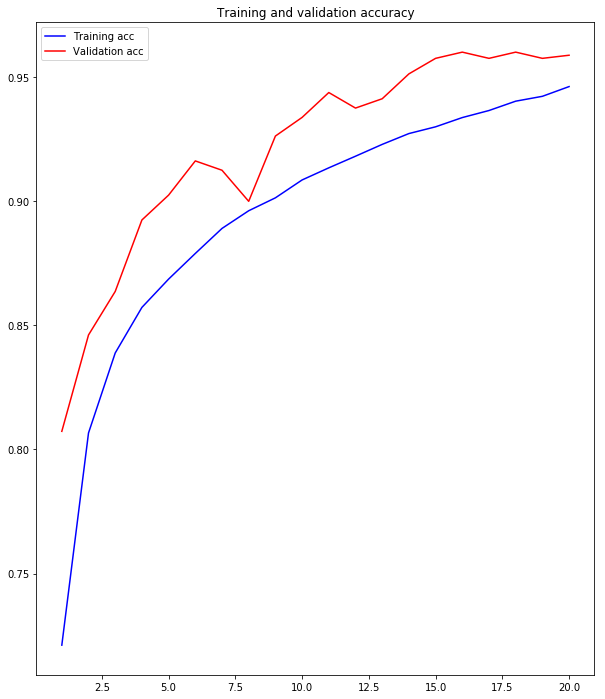

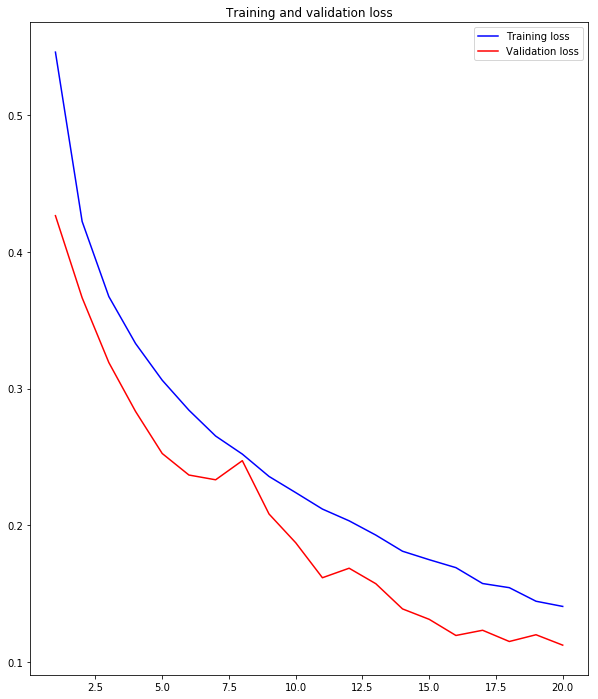

In [58]:
plot_history(history)

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)


In [ ]:
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../input/test1/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)